In [ ]:
import os, sys, time, re, pickle, datetime as dt
import warnings
warnings.filterwarnings("ignore")

import keras
from keras import regularizers
from keras.models import Model, Sequential, load_model
from keras.layers import Input, Dense, Dropout, Activation, Flatten, concatenate, Merge, Conv2D, MaxPooling2D
from keras.callbacks import Callback, ReduceLROnPlateau, ModelCheckpoint, CSVLogger
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator

import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegressionCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn import metrics

#from tqdm import tqdm

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from mpl_toolkits.axes_grid1 import ImageGrid

plt.rcParams['figure.figsize'] = [16, 10]
plt.rcParams['font.size'] = 16

sns.set_palette('muted',color_codes=True)
vc_color = '#B5C9EB'

In [ ]:
# DATA_DIR = "../data/raw/"
# TRAIN_DIR = DATA_DIR + "color_train/"
# VAL_DIR = DATA_DIR + "color_validation/"
# EXPORT_DIR = "../models/"

In [ ]:
# For compatibility with folder structure on BR's computer
DATA_DIR = "../data/raw/plant_diseases/color/30_70_hr"
TRAIN_DIR = DATA_DIR + "/train/"
VAL_DIR = DATA_DIR + "/validation/"
EXPORT_DIR = "../models/"

In [ ]:
IM_WIDTH, IM_HEIGHT = 64, 64
BATCH_SIZE = 16

In [ ]:
# Get image classes
classes = os.listdir(TRAIN_DIR)
superclasses = list(set([x.split("_")[0] for x in classes]))
superclasses.sort()
num_classes = len(classes)
num_superclasses = len(superclasses)

# Get path and label for each image
db = []
for label, class_name in enumerate(classes):
    
    superclass_name = class_name.split("_")[0]
    
    # Train
    path = TRAIN_DIR + class_name
    for file in os.listdir(path):
        db.append(['{}/{}'.format(class_name, file), label, class_name, superclass_name, 1])

    # Validation
    path = VAL_DIR + class_name
    for file in os.listdir(path):
        db.append(['{}/{}'.format(class_name, file), label, class_name, superclass_name, 0])

db = pd.DataFrame(db, columns=['file', 'label', 'class_name', 'superclass', 'train_ind'])

num_train_samples = db.train_ind.sum()
num_val_samples = len(db) - num_train_samples

In [ ]:
db.head()

In [ ]:
# Specify data generator inputs
train_datagen = ImageDataGenerator(
    rescale=1/255,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)
test_datagen = ImageDataGenerator(
    rescale=1/255)

In [ ]:
# Create data generators
train_generator = train_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=(IM_WIDTH, IM_HEIGHT),
    batch_size=BATCH_SIZE,
#     interpolation="bicubic"
)
validation_generator = test_datagen.flow_from_directory(
    VAL_DIR,
    target_size=(IM_WIDTH, IM_HEIGHT),
    batch_size=BATCH_SIZE,
#     interpolation="bicubic"
)

In [ ]:
class_id2superclass_id = np.array([superclasses.index(x.split("_")[0]) for x in classes])

def wills_two_label_generator(existing_generator, class_id2superclass_id):
    for x_data, class_one_hots in existing_generator:
        #look up superclass ids
        superclass_ids = np.dot(class_one_hots,class_id2superclass_id)
        #one-hot-encode
        batch_size = superclass_ids.shape[0]
        superclass_one_hots = np.zeros((batch_size, num_superclasses))
        superclass_one_hots[np.arange(batch_size), superclass_ids.astype(int)] = 1

        yield(x_data, {'class_output': class_one_hots, 'superclass_output': superclass_one_hots} )

In [ ]:
# Initiate optimizer
opt = keras.optimizers.adam(lr=0.001)
reduce_lr = ReduceLROnPlateau(monitor='val_acc', factor=0.2, patience=5, cooldown=5)

In [ ]:
def plot_history(history, ax, categories, labels, yaxis_label = 'Accuracy'):
    for cat, lab in zip(categories, labels):
        ax.plot(history[cat], label=lab)
    ax.set_xlabel('Epochs')
    ax.set_ylabel(yaxis_label)
    ax.legend(loc='best')

## Build Low-Parameter Superclass Model

In [ ]:
main_input_super = Input(shape=(IM_WIDTH, IM_HEIGHT, 3, ), dtype='float32', name='image_input')

#shared origin 1
conv_leaf_0 = Conv2D(32, (3, 3), padding = 'valid', activation = 'relu', name='shared_conv')(main_input_super)
pooled_leaf_0 = MaxPooling2D(pool_size =(2,2), name='shared_pool')(conv_leaf_0)

#leaf block 1
conv_leaf_1 = Conv2D(16, (3, 3), padding = 'valid', activation = 'relu', name='leaf_conv')(pooled_leaf_0)
pooled_leaf_1 = MaxPooling2D(pool_size =(2,2), name='leaf_pool')(conv_leaf_1)
dropped_leaf_1 = Dropout(0.10, name='leaf_conv_drop')(pooled_leaf_1)

#disease block 1
conv_disease_1_2 = Conv2D(64, (3, 3), padding = 'valid', activation = 'relu', name='disease_conv')(pooled_leaf_0)
pooled_disease_1 = MaxPooling2D(pool_size =(2,2), name='disease_pool')(conv_disease_1_2)
dropped_disease_1 = Dropout(0.10, name='disease_conv_drop')(pooled_disease_1)

#dense layer to predict leaf [plant type]
flat_leaf = Flatten()(dropped_leaf_1)
dense_leaf_1 = Dense(32, activation = 'relu')(flat_leaf) # Using less layers here as accuracy is less important
dense_leaf_drop = Dropout(0.3, name='leaf_dense_drop')(dense_leaf_1)
leaf_prediction = Dense(num_superclasses, activation = 'softmax', name='superclass_output')(dense_leaf_drop)

# dense layer to predict disease [plant type+disease type]
flat_disease_super = Flatten()(dropped_disease_1)
dense_disease_super = Dense(64, activation = 'relu')(flat_disease_super)

# combine networks and perform final categorization
combined_dense_disease = concatenate([dense_disease_super, leaf_prediction], axis=-1, name='final_combination')
dense_disease_drop = Dropout(0.3, name='final_drop')(combined_dense_disease)
disease_prediction = Dense(num_classes, activation = 'softmax', name='class_output')(dense_disease_drop)
model_superclass = Model(inputs=[main_input_super], outputs=[disease_prediction, leaf_prediction])

In [ ]:
# Compile model
model_superclass.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
model_superclass.summary()

In [ ]:
# Set up callbacks
model_name = "superclass_model"
filepath = EXPORT_DIR + model_name + ".hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', mode='max', verbose=1, save_best_only=True)

filepath = EXPORT_DIR + model_name + ".csv"
csv_logger = CSVLogger(filepath)

callbacks_list = [checkpoint, reduce_lr, csv_logger]

In [ ]:
# Fit generator
results = model_superclass.fit_generator(
    wills_two_label_generator(train_generator, class_id2superclass_id), epochs=40, steps_per_epoch=500, 
    validation_data=wills_two_label_generator(validation_generator, class_id2superclass_id), validation_steps=500,
    callbacks=callbacks_list)

In [ ]:
fig, ax = plt.subplots(figsize=(10,6))
plot_history(results.history, ax,
             ['class_output_acc', 'superclass_output_acc', 'val_class_output_acc', 'val_superclass_output_acc'],
             ['Class Train', 'Superclass Train', 'Class Test', 'Superclass Test'])

In [ ]:
with open('./train_history/superclass_lowparams.hist', 'wb') as file_pi:
        pickle.dump(results.history, file_pi)

## Build Low-Parameter Baseline Model

In [ ]:
# Already defined
main_input_base = Input(shape=(IM_WIDTH, IM_HEIGHT, 3, ), dtype='float32', name='image_input')
#shared origin 1
conv_leaf_base = Conv2D(32, (3, 3), padding = 'valid', activation = 'relu', name='shared_conv')(main_input_base)
pooled_leaf_base = MaxPooling2D(pool_size =(2,2), name='shared_pool')(conv_leaf_base)


# Not using
# #leaf block 1
# conv_leaf_1_2 = Conv2D(16, (3, 3), padding = 'valid', activation = 'relu', name='leaf_conv')(pooled_leaf_0)
# pooled_leaf_1 = MaxPooling2D(pool_size =(2,2), name='leaf_pool')(conv_leaf_1_2)
# dropped_leaf_1 = Dropout(0.10, name='leaf_conv_drop')(pooled_leaf_1)

#disease block 1
conv_disease_base = Conv2D(64, (3, 3), padding = 'valid', activation = 'relu', name='disease_conv')(pooled_leaf_base)
pooled_disease_base = MaxPooling2D(pool_size =(2,2), name='disease_pool')(conv_disease_base)
dropped_disease_base = Dropout(0.10, name='disease_conv_drop')(pooled_disease_base)

# dense layer to predict disease [plant type+disease type]
flat_disease_base = Flatten()(dropped_disease_base)
dense_disease_base = Dense(64, activation = 'relu')(flat_disease_base)
dense_disease_base_drop = Dropout(0.3)(dense_disease_base)

disease_prediction_base = Dense(num_classes, activation = 'softmax', name='class_output')(dense_disease_base_drop)
model_base = Model(inputs=[main_input_base], outputs=[disease_prediction_base])

In [ ]:
model_base.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

In [ ]:
model_base.summary()

In [ ]:
# Set up callbacks
model_name = "base_of_superclass_lowparams"
filepath = EXPORT_DIR + model_name + ".hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', mode='max', verbose=1, save_best_only=True)

filepath = EXPORT_DIR + model_name + ".csv"
csv_logger = CSVLogger(filepath)

callbacks_list = [checkpoint, reduce_lr, csv_logger]

In [ ]:
# Fit generator
results_base = model_base.fit_generator( train_generator, epochs=40, steps_per_epoch=500, 
    validation_data=validation_generator, validation_steps=500, callbacks=callbacks_list)

In [ ]:
with open('./train_history/baseclass_lowparams.hist', 'wb') as file_pi:
        pickle.dump(results_base.history, file_pi)

In [ ]:
fig, ax = plt.subplots(figsize=(10,6))
plot_history(results_base.history, ax,
             ['acc', 'val_acc'],
             ['Base Train', 'Base Test'])

In [ ]:
fig, ax = plt.subplots(figsize=(10,6))
plot_history(results.history, ax,
             ['class_output_acc', 'val_class_output_acc', 'superclass_output_acc', 'val_superclass_output_acc'],
             ['Superclass Disease Train', 'Superclass Disease Test', 'Superclass Leaf Train', 'Superclass Leaf Test'])
plot_history(results_base.history, ax,
             ['acc', 'val_acc'],
             ['Base Disease Train', 'Base Disease Test'])

fig.savefig("./images/superclass_comparison_lowres_full.png")

In [ ]:
fig, ax = plt.subplots(figsize=(10,6))
plot_history(results.history, ax,
             ['val_class_output_acc', 'val_superclass_output_acc'],
             ['Superclass Disease', 'Superclass Leaf'])
plot_history(results_base.history, ax,
             ['val_acc'],
             ['Base Disease'], yaxis_label="Validation Accuracy")

fig.savefig("./images/superclass_comparison_lowres.png")

## Build High-Parameter Baseline Model

In [ ]:
# Already defined
main_input_base2 = Input(shape=(IM_WIDTH, IM_HEIGHT, 3, ), dtype='float32', name='image_input')
#shared origin 1
conv_leaf_base2 = Conv2D(128, (3, 3), padding = 'valid', activation = 'relu', name='shared_conv')(main_input_base2)
pooled_leaf_base2 = MaxPooling2D(pool_size =(2,2), name='shared_pool')(conv_leaf_base2)

#disease block 1
conv_disease_base2 = Conv2D(128, (3, 3), padding = 'valid', activation = 'relu', name='disease_conv')(pooled_leaf_base2)
pooled_disease_base2 = MaxPooling2D(pool_size =(2,2), name='disease_pool')(conv_disease_base2)
dropped_disease_base2 = Dropout(0.10, name='disease_conv_drop')(pooled_disease_base2)

# dense layer to predict disease [plant type+disease type]
flat_disease_base2 = Flatten()(dropped_disease_base2)
dense_disease_base2 = Dense(128, activation = 'relu')(flat_disease_base2)
dense_disease_base_drop2 = Dropout(0.3)(dense_disease_base2)

disease_prediction_base2 = Dense(num_classes, activation = 'softmax', name='class_output')(dense_disease_base_drop2)
model_base2 = Model(inputs=[main_input_base2], outputs=[disease_prediction_base2])

In [ ]:
model_base2.summary()

In [ ]:
model_base2.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

In [ ]:
# Set up callbacks
model_name = "base_of_superclass_highparam_model"
filepath = EXPORT_DIR + model_name + ".hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', mode='max', verbose=1, save_best_only=True)

filepath = EXPORT_DIR + model_name + ".csv"
csv_logger = CSVLogger(filepath)
callbacks_list = [checkpoint, reduce_lr, csv_logger]

In [ ]:
# Fit generator
results_base2 = model_base2.fit_generator( train_generator, epochs=40, steps_per_epoch=500, 
    validation_data=validation_generator, validation_steps=500, callbacks=callbacks_list)

In [ ]:
fig, ax = plt.subplots(figsize=(10,6))
plot_history(results_base2.history, ax,
             ['acc', 'val_acc'],
             ['Base Train', 'Base Test'])

In [ ]:
with open('./train_history/baseclass_highparams.hist', 'wb') as file_pi:
        pickle.dump(results_base2.history, file_pi)

## Build High-Parameter Baseline Model

In [ ]:
main_input_super2 = Input(shape=(IM_WIDTH, IM_HEIGHT, 3, ), dtype='float32', name='image_input')

#shared origin 1
conv_super2 = Conv2D(128, (3, 3), padding = 'valid', activation = 'relu', name='shared_conv')(main_input_super2)
pooled_super2 = MaxPooling2D(pool_size =(2,2), name='shared_pool')(conv_super2)

#leaf block 1
conv_leaf_super2 = Conv2D(32, (3, 3), padding = 'valid', activation = 'relu', name='leaf_conv')(pooled_super2)
pooled_leaf_super2 = MaxPooling2D(pool_size =(2,2), name='leaf_pool')(conv_leaf_super2)
dropped_leaf_super2 = Dropout(0.10, name='leaf_conv_drop')(pooled_leaf_super2)

#disease block 1
conv_disease_super2 = Conv2D(128, (3, 3), padding = 'valid', activation = 'relu', name='disease_conv')(pooled_super2)
pooled_disease_super2 = MaxPooling2D(pool_size =(2,2), name='disease_pool')(conv_disease_super2)
dropped_disease_super2 = Dropout(0.10, name='disease_conv_drop')(pooled_disease_super2)

#dense layer to predict leaf [plant type]
flat_leaf_super2 = Flatten()(dropped_leaf_super2)
dense_leaf_super2 = Dense(64, activation = 'relu')(flat_leaf_super2) # Using less layers here as accuracy is less important
dense_leaf_drop_super2 = Dropout(0.3, name='leaf_dense_drop')(dense_leaf_super2)
leaf_prediction_super2 = Dense(num_superclasses, activation = 'softmax', name='superclass_output')(dense_leaf_drop_super2)

# dense layer to predict disease [plant type+disease type]
flat_disease_super2 = Flatten()(dropped_disease_super2)
dense_disease_super2 = Dense(128, activation = 'relu')(flat_disease_super2)

# combine networks and perform final categorization
combined_dense_disease_super2 = concatenate([dense_disease_super2, leaf_prediction_super2], axis=-1, name='final_combined')
dense_disease_drop_super2 = Dropout(0.3, name='final_drop')(combined_dense_disease_super2)

disease_prediction_super2 = Dense(num_classes, activation = 'softmax', name='class_output')(dense_disease_drop_super2)
model_superclass_2 = Model(inputs=[main_input_super2], outputs=[disease_prediction_super2, leaf_prediction_super2])

In [ ]:
model_superclass_2.summary()

In [ ]:
# Compile model
model_superclass_2.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

In [ ]:
# Set up callbacks
model_name = "superclass_model_highparams"
filepath = EXPORT_DIR + model_name + ".hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', mode='max', verbose=1, save_best_only=True)

filepath = EXPORT_DIR + model_name + ".csv"
csv_logger = CSVLogger(filepath)

callbacks_list = [checkpoint, reduce_lr, csv_logger]

In [ ]:
# Fit generator
results_superclass2 = model_superclass_2.fit_generator(
    wills_two_label_generator(train_generator, class_id2superclass_id),
    epochs=40,
    steps_per_epoch=500, 
    validation_data=wills_two_label_generator(validation_generator, class_id2superclass_id),
    validation_steps=500,
    callbacks=callbacks_list)

In [ ]:
fig, ax = plt.subplots(figsize=(10,6))
plot_learning_curve(results_superclass2, ax)

In [ ]:
with open('./train_history/superclass_highparams.hist', 'wb') as file_pi:
        pickle.dump(results_superclass2.history, file_pi)

In [ ]:
results_superclass2_load = pickle.load( open('./train_history/superclass_highparams.hist', "rb" ) )

In [ ]:
type(results_superclass2.history)

In [ ]:
results_superclass2_load.keys()

In [ ]:
fig, ax = plt.subplots(figsize=(10,6))
plot_history(results_superclass2_load, ax, 
             categories=['val_class_output_acc', 'val_superclass_output_acc'], 
             labels=['Class Test', 'Superclass Test'])

In [28]:
with open('./train_history/superclass_highparams.hist', 'wb') as file_pi:
        pickle.dump(results_superclass2.history, file_pi)

In [30]:
results_superclass2_load = pickle.load( open('./train_history/superclass_highparams.hist', "rb" ) )

In [33]:
type(results_superclass2.history)

dict

In [36]:
results_superclass2_load.keys()

dict_keys(['val_loss', 'val_class_output_loss', 'val_superclass_output_loss', 'val_class_output_acc', 'val_superclass_output_acc', 'loss', 'class_output_loss', 'superclass_output_loss', 'class_output_acc', 'superclass_output_acc', 'lr'])

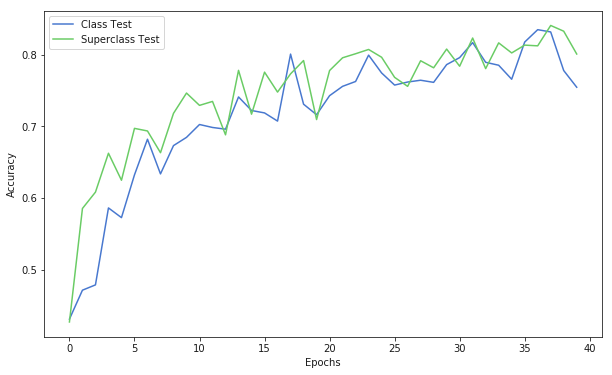

In [37]:
fig, ax = plt.subplots(figsize=(10,6))
plot_history(results_superclass2_load, ax, 
             categories=['val_class_output_acc', 'val_superclass_output_acc'], 
             labels=['Class Test', 'Superclass Test'])